[View in Colaboratory](https://colab.research.google.com/github/suzuki-tr/tensorflow-study/blob/master/tensorflow_retrain.ipynb)

In [54]:
!pwd
!ls

/content
bottleneck  datalab  flower_photos  flower_photos.tgz  tmp


# Retrain
[How to Retrain an Image Classifier for New Categories](https://www.tensorflow.org/tutorials/image_retraining)

In [2]:
!pwd
!curl -LO http://download.tensorflow.org/example_images/flower_photos.tgz
!tar xzf flower_photos.tgz
!ls

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0   109M      0  0:00:02  0:00:02 --:--:-- 72.9M
datalab  flower_photos	flower_photos.tgz


In [3]:
!pip install tensorflow_hub

    100% |████████████████████████████████| 61kB 2.3MB/s 


In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os

## Data Augumentation

In [55]:
!pip install pillow

In [0]:
def gamma_table(gamma_r, gamma_g, gamma_b, gain_r=1.0, gain_g=1.0, gain_b=1.0):
    r_tbl = [min(255, int((x / 255.) ** (1. / gamma_r) * gain_r * 255.)) for x in range(256)]
    g_tbl = [min(255, int((x / 255.) ** (1. / gamma_g) * gain_g * 255.)) for x in range(256)]
    b_tbl = [min(255, int((x / 255.) ** (1. / gamma_b) * gain_b * 255.)) for x in range(256)]
    return r_tbl + g_tbl + b_tbl

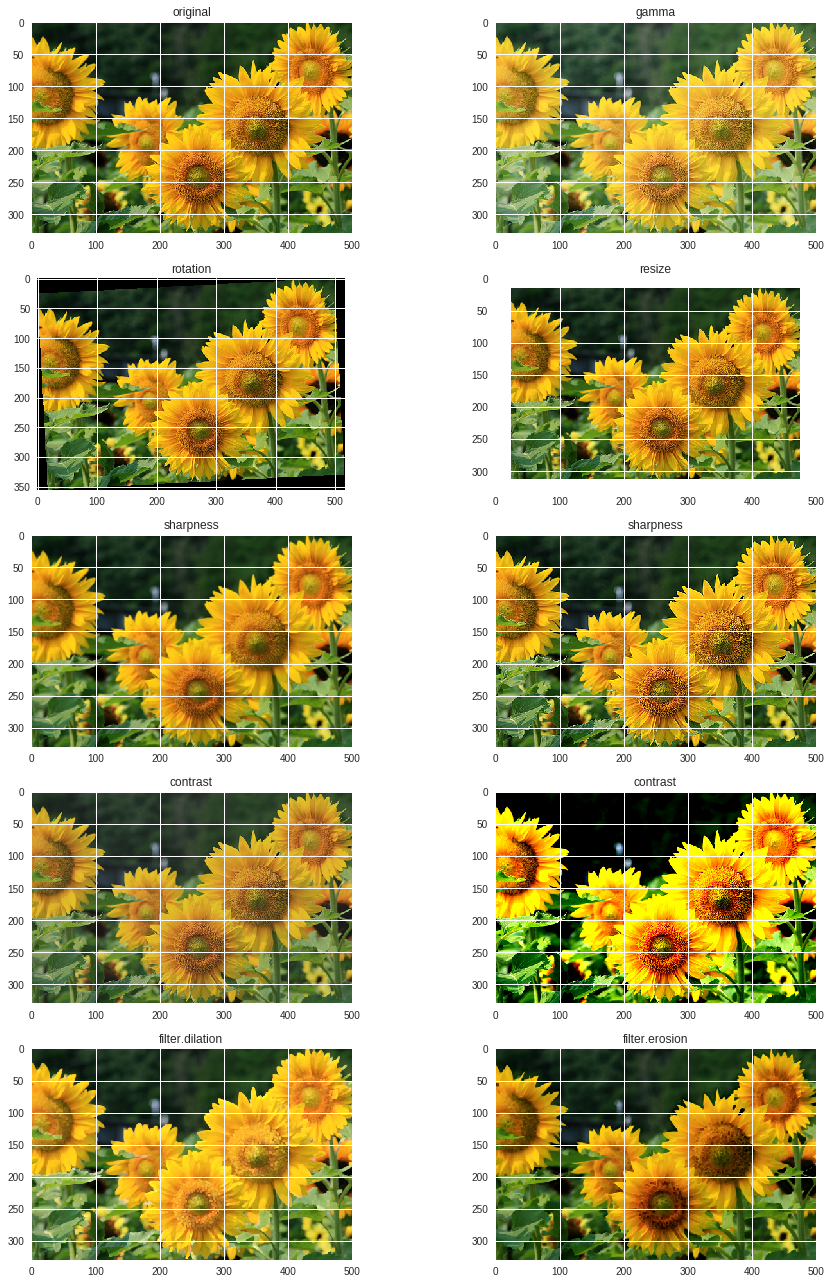

In [18]:
#https://pillow.readthedocs.io/en/5.1.x/reference/ImageEnhance.html
from matplotlib import pyplot as plt
from PIL import Image,ImageEnhance,ImageFilter
import numpy
image_path = 'flower_photos/sunflowers/1008566138_6927679c8a.jpg'

im = Image.open(image_path)

fig = plt.figure(figsize=(14,18))
ax = fig.add_subplot(521)
ax.set_title('original')
ax.imshow(im)

im_gamma = im.point(gamma_table(1.5,1.5,1.5))
ax = fig.add_subplot(522)
ax.set_title('gamma')
ax.imshow(im_gamma)

im_rotate = im.rotate(3 , expand=True, resample=Image.BICUBIC)
ax = fig.add_subplot(523)
ax.set_title('rotation')
ax.imshow(im_rotate)

imgArray = numpy.asarray(im)
height,width,channel = imgArray.shape
im_resize = im.resize((int(width*0.9),int(height*0.9)))
im_resizeArray = numpy.asarray(im_resize)
im_scaleArray = numpy.ones_like(imgArray)*255
xpos = int((imgArray.shape[1] - im_resizeArray.shape[1])/2)
ypos = int((imgArray.shape[0] - im_resizeArray.shape[0])/2)
im_scaleArray[ypos:im_resizeArray.shape[0]+ypos,xpos:im_resizeArray.shape[1]+xpos,:] = im_resizeArray
im_scale = Image.fromarray(numpy.uint8(im_scaleArray))
ax = fig.add_subplot(524)
ax.set_title('resize')
ax.imshow(im_scale)

enhancer = ImageEnhance.Sharpness(im)
ax = fig.add_subplot(525)
ax.set_title('sharpness')
ax.imshow(enhancer.enhance(0.0))
ax = fig.add_subplot(526)
ax.set_title('sharpness')
ax.imshow(enhancer.enhance(2.0))

enhancer = ImageEnhance.Contrast(im)
ax = fig.add_subplot(527)
ax.set_title('contrast')
ax.imshow(enhancer.enhance(0.8))
ax = fig.add_subplot(528)
ax.set_title('contrast')
ax.imshow(enhancer.enhance(2.0))

ax = fig.add_subplot(529)
ax.set_title('filter.dilation')
ax.imshow(im.filter(ImageFilter.MaxFilter(3)))
ax = fig.add_subplot(5,2,10)
ax.set_title('filter.erosion')
ax.imshow(im.filter(ImageFilter.MinFilter(3)))


plt.tight_layout()
plt.gray()
plt.show()

# Create features
reference code is [retrain.py](https://github.com/tensorflow/hub/blob/r0.1/examples/image_retraining/retrain.py)

In [5]:
module_spec = hub.load_module_spec('https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/1')

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/1'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/1'.


In [0]:
def run_bottleneck_on_image(sess, image_data, image_data_tensor,
                            decoded_image_tensor, resized_input_tensor,
                            bottleneck_tensor):
  # First decode the JPEG image, resize it, and rescale the pixel values.
  resized_input_values = sess.run(decoded_image_tensor,{image_data_tensor: image_data})
  # Then run it through the recognition network.
  bottleneck_values = sess.run(bottleneck_tensor,{resized_input_tensor: resized_input_values})
  bottleneck_values = np.squeeze(bottleneck_values)
  return bottleneck_values

In [0]:
def create_bottleneck_file(bottleneck_path, image_path, sess, jpeg_data_tensor,
                           decoded_image_tensor, resized_input_tensor, bottleneck_tensor):
  tf.logging.info('Creating bottleneck at ' + bottleneck_path)
  image_data = tf.gfile.FastGFile(image_path, 'rb').read()
  try:
    bottleneck_values = run_bottleneck_on_image(
        sess, image_data, jpeg_data_tensor, decoded_image_tensor,
        resized_input_tensor, bottleneck_tensor)
  except Exception as e:
    raise RuntimeError('Error during processing file %s (%s)' % (image_path, str(e)))
  bottleneck_string = ','.join(str(x) for x in bottleneck_values)
  with open(bottleneck_path, 'w') as bottleneck_file:
    bottleneck_file.write(bottleneck_string)

In [0]:
def create_module_graph(module_spec):
  FAKE_QUANT_OPS = ('FakeQuantWithMinMaxVars','FakeQuantWithMinMaxVarsPerChannel')
  height, width = hub.get_expected_image_size(module_spec)
  with tf.Graph().as_default() as graph:
    resized_input_tensor = tf.placeholder(tf.float32, [None, height, width, 3])
    m = hub.Module(module_spec)
    bottleneck_tensor = m(resized_input_tensor)
    wants_quantization = any(node.op in FAKE_QUANT_OPS
                             for node in graph.as_graph_def().node)
  return graph, bottleneck_tensor, resized_input_tensor, wants_quantization    

In [0]:
def add_jpeg_decoding(module_spec):
  input_height, input_width = hub.get_expected_image_size(module_spec)
  input_depth = hub.get_num_image_channels(module_spec)
  jpeg_data = tf.placeholder(tf.string, name='DecodeJPGInput')
  decoded_image = tf.image.decode_jpeg(jpeg_data, channels=input_depth)
  # Convert from full range of uint8 to range [0,1] of float32.
  decoded_image_as_float = tf.image.convert_image_dtype(decoded_image,tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  resize_shape = tf.stack([input_height, input_width])
  resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
  resized_image = tf.image.resize_bilinear(decoded_image_4d,
                                           resize_shape_as_int)
  return jpeg_data, resized_image

In [0]:
def create_image_lists(image_dir):
  result = {} #{class1:[filepath1,filepath2,],class2:[],}
  sub_dirs = sorted(x[0] for x in tf.gfile.Walk(image_dir))
  for sub_dir in sub_dirs:
    file_list = []
    if sub_dir is image_dir:
      continue
    dir_name = os.path.basename(sub_dir) # = classname
    extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
    for extension in extensions:
      file_glob = os.path.join(image_dir, dir_name, '*.' + extension)
      file_list.extend(tf.gfile.Glob(file_glob))
    result[dir_name] = file_list
  return result

In [57]:
IMAGES_DIR = 'flower_photos'
BOTTLENECK_DIR = 'bottleneck'
ARCHITECTURE = 'mobilenet-v2'
print('checking image files and createing bottleneck feature descriptors...')
image_lists = create_image_lists(IMAGES_DIR)
class_count = len(image_lists.keys())
graph, bottleneck_tensor, resized_input_tensor, wants_quantization = create_module_graph(module_spec)
with graph.as_default():
  jpeg_data_tensor, decoded_image_tensor = add_jpeg_decoding(module_spec)
  with tf.Session(graph=graph) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for classname in image_lists.keys():
      print(classname, len(image_lists[classname]))
      for image_path in image_lists[classname][1:100]:
        bottleneck_path = image_path.replace(IMAGES_DIR, BOTTLENECK_DIR) + '_' + ARCHITECTURE + '.txt'
        if not os.path.exists(os.path.dirname(bottleneck_path)):
          os.makedirs(os.path.dirname(bottleneck_path))
        create_bottleneck_file(bottleneck_path, image_path, sess, jpeg_data_tensor,
                               decoded_image_tensor, resized_input_tensor, bottleneck_tensor)
print('created features are...')
!ls -la bottleneck

checking image files and createing bottleneck feature descriptors...
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable modul

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with Mobilenet


INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_16/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_5/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_6/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_8

INFO:tensorflow:Creating bottleneck at bottleneck/daisy/14264136211_9531fbc144.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/14551098743_2842e7a004_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/2019064575_7656b9340f_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/20948886919_cac7844f34_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/8719756744_34a5a83976_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/9350942387_5b1d043c26_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/3474942718_c418dae6f1.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/4724713781_d169f98a35.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/299129811_d6ebda9970.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/3285641623_da0e47f49a.jpg_mobilenet-v2.tx

INFO:tensorflow:Creating bottleneck at bottleneck/daisy/1314069875_da8dc023c6_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/5632774792_0fa33d17eb_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/12891819633_e4c82b51e8.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/813445367_187ecf080a_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/7416083788_fcb4c4f27e_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/54377391_15648e8d18.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/2642408410_61545fdc83_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/9922116524_ab4a2533fe_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/173350276_02817aa8d5.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/19280272025_57de24e940_m.jpg_mobilenet-v2.tx

INFO:tensorflow:Creating bottleneck at bottleneck/daisy/16833748795_b681b2839f_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/7358085448_b317d11cd5.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/3758221664_b19116d61f.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/2635314490_e12d3b0f36_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/18474740346_ffdaa18032.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/5693459303_e61d9a9533.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/13826249325_f61cb15f86_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/695778683_890c46ebac.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/18442919723_d1251d3e14_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/daisy/4268817944_cdbdb226ae.jpg_mobilenet-v2.txt

INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/10043234166_e6dd915111_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/9726260379_4e8ee66875_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/8969938579_4c2032dd96_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/4265711814_9a006ee5b8.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/14093789753_f0f1acdb57.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/6954604340_d3223ed296_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/506660896_c903cca1f0.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/18238604119_a5689980ee_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/4523239455_9c31a06aaf_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion

INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/15987457_49dc11bf4b.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/10443973_aeb97513fc_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/19600096066_67dc941042.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/1443259657_2704fab26e_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/11296320473_1d9261ddcb.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/6146107825_45f708ecd7_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/2473862606_291ae74885.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/4575406391_7a62c5f90f_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/7132676187_7a4265b16f_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/dandelion/45744

INFO:tensorflow:Creating bottleneck at bottleneck/roses/18389368680_91c24a2087_z.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/5529341024_0c35f2657d.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/8742493689_fb852f0228_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/4684127262_6c3346188d.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/15949087094_a8f565295c_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/8394286483_69fe04cc7f.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/6280787884_141cd7b382_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/14221192676_eb8c89a7d6_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/10894627425_ec76bbc757_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/3751835302_d5a03f55e8_n.jpg_mobilenet

INFO:tensorflow:Creating bottleneck at bottleneck/roses/3292654244_4a220ab96f_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/15697872479_ed48e9dd73_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/5273722065_c85d8543c2_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/5086249859_d066b37b8a_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/8747396730_966149e6fe_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/12407768513_3440238148_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/19440805164_920b28da61_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/2568105249_15720d081f_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/8562144481_1d629848ff.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/roses/160954292_6c2b4fda65_n.jpg_mobilen

INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/18237156988_9ceb46a8de_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/4871455214_8b5fb87ab6_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/4042816698_578a1d599e.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/4673984698_6ec14d5b79.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/5979111025_3bcae48ae6_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/3334350831_f8755a2095_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/4868595281_1e58083785.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/8021568040_f891223c44_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/2894191705_a1d2d80c80.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sun

INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/6606823367_e89dc52a95_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/8705462313_4458d64cd4.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/2721638730_34a9b7a78b.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/215798352_184d8040d1.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/3749091071_c146b33c74_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/5139969871_c9046bdaa7_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/9240005603_6a9b71dcea_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/14623720226_aeeac66e0a_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/14121915990_4b76718077_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/s

INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/40411100_7fbe10ec0f_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/145303599_2627e23815_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/23356825566_f5885875f2.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/sunflowers/1715303025_e7065327e2.jpg_mobilenet-v2.txt
tulips 799
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/5811022098_2523ca4e82.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/6958243974_8851425ddb_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/2834890466_1cf220fba1.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/3253320570_b617f7fd4b.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/11746452_5bc1749a36.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/16862351376_f0

INFO:tensorflow:Creating bottleneck at bottleneck/tulips/14087326141_1906d5a373_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/5543457754_89c44c88de_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/14093884601_c87b5cd663_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/7481217920_6f65766a1c_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/8712270243_8512cf4fbd.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/8687675254_c93f50d8b0_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/13997641965_80d5dab542_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/13910471347_30c8bf4de1_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/8521597402_4b6169ba05.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/65347450_53658c63bd_n.jpg

INFO:tensorflow:Creating bottleneck at bottleneck/tulips/16309287412_5cc4d58bd1_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/5430796647_f21b7b0fea.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/137126311_debe64c6a8_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/9870557734_88eb3b9e3b_n.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/5757091018_cdfd79dfa6_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/15452909878_0c4941f729_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/15275190769_0ed7bbf490.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/8668973377_c69527db42_m.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/17012955700_7141d29eee.jpg_mobilenet-v2.txt
INFO:tensorflow:Creating bottleneck at bottleneck/tulips/6931715360_34edc5a372_m.jpg_

## Retrain using created bottleneck file

In [0]:
FINAL_TENSOR_NAME = 'final_result'
CHECKPOINT_NAME   = 'tmp/_retrain_checkpoint'
OUTPUT_GRAPH      = 'tmp/output_graph.pb'
SAVED_MODEL_DIR   = 'tmp/output'
OUTPUT_LABEL      = 'tmp/output_labels.txt'
LOGDIR            = 'tmp/logdir'



In [0]:
def create_bottleneck_lists(bottleneck_dir):
  result = {} #{class1:[filepath1,filepath2,],class2:[],}
  sub_dirs = sorted(x[0] for x in tf.gfile.Walk(bottleneck_dir))
  for sub_dir in sub_dirs:
    file_list = []
    if sub_dir is bottleneck_dir:
      continue
    dir_name = os.path.basename(sub_dir) # = classname
    extensions = ['txt', 'TXT']
    for extension in extensions:
      file_glob = os.path.join(bottleneck_dir, dir_name, '*.' + extension)
      file_list.extend(tf.gfile.Glob(file_glob))
    result[dir_name] = file_list
  return result

In [0]:
# for tensorboard
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var) #平均
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [0]:
LEARNING_RATE = 0.01
def add_final_retrain_ops(class_count, final_tensor_name, bottleneck_tensor, quantize_layer, is_training):
  print('add_final_retrain_ops (is_training:{})'.format(is_training))

  batch_size, bottleneck_tensor_size = bottleneck_tensor.get_shape().as_list()
  print('batch_size {}, bottleneck_tensor_size{}'.format(batch_size, bottleneck_tensor_size))
  
  with tf.name_scope('input'):
    bottleneck_input = tf.placeholder_with_default(
        bottleneck_tensor, shape=[batch_size, bottleneck_tensor_size], name='BottleneckInputPlaceholder') #input/BottleneckInputPlaceholder
    ground_truth_input = tf.placeholder(tf.int64, [batch_size], name='GroundTruthInput') #input/GroundTruthInput
    
  #layer_name = 'final_retrain_ops'
  with tf.name_scope('final_retrain_ops'):
    with tf.name_scope('weights'):
      #±2σの切断正規分布からランダムに取り出したテンソルを生成->初期値とする
      initial_value = tf.truncated_normal([bottleneck_tensor_size, class_count], stddev=0.001)
      layer_weights = tf.Variable(initial_value, name='final_weights') #final_retrain_ops/weights/final_weights
      variable_summaries(layer_weights) #for tensorboard

  with tf.name_scope('biases'):
    layer_biases = tf.Variable(tf.zeros([class_count]), name='final_biases') #biases/final_biases
    variable_summaries(layer_biases)

  with tf.name_scope('Wx_plus_b'):
    logits = tf.matmul(bottleneck_input, layer_weights) + layer_biases #Wx_plus_b/Logits
    tf.summary.histogram('pre_activations', logits)

  final_tensor = tf.nn.softmax(logits, name=final_tensor_name) #final_tensor

  #for final layer will be transformed.
  if quantize_layer: 
    if is_training:
      tf.contrib.quantize.create_training_graph()
    else:
      tf.contrib.quantize.create_eval_graph()

  tf.summary.histogram('activations', final_tensor)

  if not is_training:
    return None, None, bottleneck_input, ground_truth_input, final_tensor

  with tf.name_scope('cross_entropy'):
    cross_entropy_mean = tf.losses.sparse_softmax_cross_entropy(
        labels=ground_truth_input, logits=logits)
  tf.summary.scalar('cross_entropy', cross_entropy_mean)

  with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
    train_step = optimizer.minimize(cross_entropy_mean)

  return (train_step, cross_entropy_mean, bottleneck_input, ground_truth_input,final_tensor)

In [0]:
def add_evaluation_step(result_tensor, ground_truth_tensor):
  """Inserts the operations we need to evaluate the accuracy of our results.
  Args:
    result_tensor: The new final node that produces results.
    ground_truth_tensor: The node we feed ground truth data
    into.
  Returns:
    Tuple of (evaluation step, prediction).
  """
  with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'): #accuracy/correct_prediction
      prediction = tf.argmax(result_tensor, 1)
      correct_prediction = tf.equal(prediction, ground_truth_tensor)
    with tf.name_scope('accuracy'): #accuracy/accuracy
      evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('accuracy', evaluation_step)
  return evaluation_step, prediction

In [0]:
def build_eval_session(module_spec, class_count):
  """Builds an restored eval session without train operations for exporting.
  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: Number of classes
  Returns:
    Eval session containing the restored eval graph.
    The bottleneck input, ground truth, eval step, and prediction tensors.
  """
  # If quantized, we need to create the correct eval graph for exporting.
  eval_graph, bottleneck_tensor, resized_input_tensor, wants_quantization = (
      create_module_graph(module_spec))

  eval_sess = tf.Session(graph=eval_graph)
  with eval_graph.as_default():
    # Add the new layer for exporting.
    (_, _, bottleneck_input,
     ground_truth_input, final_tensor) = add_final_retrain_ops(
         class_count, FINAL_TENSOR_NAME, bottleneck_tensor,
         wants_quantization, is_training=False)

    # Now we need to restore the values from the training graph to the eval
    # graph.
    tf.train.Saver().restore(eval_sess, CHECKPOINT_NAME)
    evaluation_step, prediction = add_evaluation_step(final_tensor, ground_truth_input)

  return (eval_sess, resized_input_tensor, bottleneck_input, ground_truth_input, evaluation_step, prediction)

In [0]:
def save_graph_to_file(graph, graph_file_name, module_spec, class_count):
  """Saves an graph to file, creating a valid quantized one if necessary."""
  sess, _, _, _, _, _ = build_eval_session(module_spec, class_count)
  graph = sess.graph

  #tf.Variableの代わりにtf.constantを使うようにしたグラフ
  output_graph_def = tf.graph_util.convert_variables_to_constants(
      sess, graph.as_graph_def(), [FINAL_TENSOR_NAME])

  with tf.gfile.FastGFile(graph_file_name, 'wb') as f:
    f.write(output_graph_def.SerializeToString())

In [0]:
'''
def export_model(module_spec, class_count, saved_model_dir):
  """Exports model for serving.
  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: The number of classes.
    saved_model_dir: Directory in which to save exported model and variables.
  """
  # The SavedModel should hold the eval graph.
  sess, in_image, _, _, _, _ = build_eval_session(module_spec, class_count)
  graph = sess.graph
  with graph.as_default():
    inputs = {'image': tf.saved_model.utils.build_tensor_info(in_image)}

    out_classes = sess.graph.get_tensor_by_name('final_result:0')
    outputs = {
        'prediction': tf.saved_model.utils.build_tensor_info(out_classes) #A TensorInfo protocol buffer constructed based on the supplied argument.
    }

    signature = tf.saved_model.signature_def_utils.build_signature_def(
        inputs=inputs,
        outputs=outputs,
        method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME)

    legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')

    # Save out the SavedModel.
    builder = tf.saved_model.builder.SavedModelBuilder(saved_model_dir)
    builder.add_meta_graph_and_variables(
        sess, [tf.saved_model.tag_constants.SERVING],
        signature_def_map={
            tf.saved_model.signature_constants.
            DEFAULT_SERVING_SIGNATURE_DEF_KEY:
                signature
        },
        legacy_init_op=legacy_init_op)
    builder.save()
'''

In [0]:
def get_bottleneck_data(bottleneck_path):
  with open(bottleneck_path, 'r') as bottleneck_file:
      bottleneck_string = bottleneck_file.read()
  bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  return bottleneck_values

In [0]:
import random
def get_bottlenecks(bottleneck_lists, minibatch=10):
  class_count = len(bottleneck_lists.keys())
  bottlenecks = []
  ground_truths = []
  if minibatch >= 0:
    for unused_i in range(minibatch):
      label_index = random.randrange(class_count)
      label_name = list(bottleneck_lists.keys())[label_index]
      file_index = random.randrange(len(bottleneck_lists[label_name]))
      file_path = bottleneck_lists[label_name][file_index]
      bottleneck = get_bottleneck_data(file_path)
      bottlenecks.append(bottleneck)
      ground_truths.append(label_index)
    #for label_index, label_name in enumerate(bottleneck_lists.keys()):
    #  for index, file_path in enumerate(bottleneck_lists[label_name]):
    #    bottleneck = get_bottleneck_data(file_path)
    #    bottlenecks.append(bottleneck)
    #    ground_truths.append(label_index)
  print('bottleneck count:{}, ground truth:{}'.format(len(bottlenecks),len(ground_truths)))
  return bottlenecks, ground_truths

In [62]:
if not os.path.isdir(LOGDIR):
  os.makedirs(LOGDIR)

bottleneck_lists = create_bottleneck_lists('bottleneck')
class_count = len(bottleneck_lists.keys())

print('class count',class_count)
for classname in bottleneck_lists.keys():
  print('{} {}'.format(classname,len(bottleneck_lists[classname])))

graph, bottleneck_tensor, resized_input_tensor, wants_quantization = create_module_graph(module_spec)
with graph.as_default():
  #jpeg_data_tensor, decoded_image_tensor = add_jpeg_decoding(module_spec)
  
  (train_step, cross_entropy, bottleneck_input,
   ground_truth_input, final_tensor) = add_final_retrain_ops(
      class_count, FINAL_TENSOR_NAME, bottleneck_tensor,wants_quantization, is_training=True)
  
  with tf.Session(graph=graph) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    train_writer = tf.summary.FileWriter(LOGDIR + '/train',sess.graph)#log
    train_saver = tf.train.Saver()
    merged = tf.summary.merge_all()

    for i in range(100):
      print('step:',i)
      train_bottlenecks,train_ground_truth = get_bottlenecks(bottleneck_lists)

      train_summary, _ = sess.run(
          [merged, train_step],
          feed_dict={bottleneck_input: train_bottlenecks,
                     ground_truth_input: train_ground_truth})
      train_writer.add_summary(train_summary, i)
      #print('train_step',train_step)
    train_saver.save(sess, CHECKPOINT_NAME)
      
    save_graph_to_file(graph, OUTPUT_GRAPH, module_spec, class_count)
    #export_model(module_spec, class_count, SAVED_MODEL_DIR)
    with tf.gfile.FastGFile(OUTPUT_LABEL, 'w') as f:
      f.write('\n'.join(bottleneck_lists.keys()) + '\n')

class count 5
daisy 100
dandelion 100
roses 100
sunflowers 100
tulips 100
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable 

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_14/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_3/pro


INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_6/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded

bottleneck count:10, ground truth:10
step: 63
bottleneck count:10, ground truth:10
step: 64
bottleneck count:10, ground truth:10
step: 65
bottleneck count:10, ground truth:10
step: 66
bottleneck count:10, ground truth:10
step: 67
bottleneck count:10, ground truth:10
step: 68
bottleneck count:10, ground truth:10
step: 69
bottleneck count:10, ground truth:10
step: 70
bottleneck count:10, ground truth:10
step: 71
bottleneck count:10, ground truth:10
step: 72
bottleneck count:10, ground truth:10
step: 73
bottleneck count:10, ground truth:10
step: 74
bottleneck count:10, ground truth:10
step: 75
bottleneck count:10, ground truth:10
step: 76
bottleneck count:10, ground truth:10
step: 77
bottleneck count:10, ground truth:10
step: 78
bottleneck count:10, ground truth:10
step: 79
bottleneck count:10, ground truth:10
step: 80
bottleneck count:10, ground truth:10
step: 81
bottleneck count:10, ground truth:10
step: 82
bottleneck count:10, ground truth:10
step: 83
bottleneck count:10, ground truth:

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_10/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_12/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_15/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchN


INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_5/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded


INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/33f8428fe83945b8b3d46d79168a0e2818e65e8a/variables/variables' with MobilenetV2/expanded_c

In [63]:
!ls -la tmp

total 36732
drwxr-xr-x 3 root root     4096 May  3 11:17 .
drwxr-xr-x 1 root root     4096 May  3 07:41 ..
-rw-r--r-- 1 root root       95 May  3 11:17 checkpoint
drwxr-xr-x 3 root root     4096 May  3 07:43 logdir
-rw-r--r-- 1 root root 17637205 May  3 11:17 output_graph.pb
-rw-r--r-- 1 root root       40 May  3 11:17 output_labels.txt
-rw-r--r-- 1 root root 17490708 May  3 11:17 _retrain_checkpoint.data-00000-of-00001
-rw-r--r-- 1 root root    11189 May  3 11:17 _retrain_checkpoint.index
-rw-r--r-- 1 root root  2447620 May  3 11:17 _retrain_checkpoint.meta


# Classify with trained model

In [0]:
def read_tensor_from_image_file(file_name,
                                input_height=224,
                                input_width=224,
                                input_mean=0,
                                input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  image_reader = tf.image.decode_jpeg(file_reader, channels=3, name="jpeg_reader")
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0)
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result


In [66]:
MODELFILE = 'tmp/output_graph.pb'

def classify_image():

  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(MODELFILE, "rb") as f:
    graph_def.ParseFromString(f.read())

  imagelist=['flower_photos/daisy/100080576_f52e8ee070_n.jpg',
             'flower_photos/dandelion/10043234166_e6dd915111_n.jpg',
             'flower_photos/roses/10090824183_d02c613f10_m.jpg',
             'flower_photos/sunflowers/1008566138_6927679c8a.jpg',
             'flower_photos/tulips/100930342_92e8746431_n.jpg'
            ]
      
  with graph.as_default():
    tf.import_graph_def(graph_def)
    with tf.Session(graph=graph) as sess:
      
      #[ print(op.name) for op in sess.graph.get_operations()]
      
      input_operation = graph.get_operation_by_name('import/Placeholder')
      output_operation = graph.get_operation_by_name('import/final_result')
      #print(input_operation,output_operation)

      for filepath in imagelist:
        t = read_tensor_from_image_file(filepath)

        results = sess.run(output_operation.outputs[0], {
          input_operation.outputs[0]: t
          })
        results = np.squeeze(results)
        print(filepath,np.argmax(results),results)

classify_image()

flower_photos/daisy/100080576_f52e8ee070_n.jpg 0 [0.7559124  0.051971   0.00771938 0.15938199 0.0250153 ]
flower_photos/dandelion/10043234166_e6dd915111_n.jpg 1 [1.7145663e-03 9.9085009e-01 3.0700034e-03 3.8237244e-04 3.9830087e-03]
flower_photos/roses/10090824183_d02c613f10_m.jpg 2 [0.14093584 0.13157138 0.4195705  0.03291738 0.27500492]
flower_photos/sunflowers/1008566138_6927679c8a.jpg 3 [0.02715476 0.06524239 0.00888455 0.88379663 0.01492167]
flower_photos/tulips/100930342_92e8746431_n.jpg 4 [0.05543648 0.07851893 0.10567393 0.02905678 0.7313139 ]
